In [5]:
import pandas as pd
import numpy as np
from os import listdir
from sklearn import datasets
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt

# Preproceso del set de entrenamiento

# Funciones del uso de informacion del campo de descripcion

In [6]:
def isFloat(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

In [7]:
false = 0
true = 1
# ------------------------------------------------------------------------------
# INICIALIZAR DICCIONARIO
# ------------------------------------------------------------------------------
# pre: Recibe una lista de claves
# pos: devuelve un diccionario de esas claves recibidas inicializadas en cero

def inicializar_diccionario(keys):
    dicc = {}
    for charac in keys:
        dicc[charac] = 0
    return dicc

#------------------------------------------------------
# GET SURFACE
#------------------------------------------------------
def getSurface(df):
    surfaces = df['surface_total_in_m2'].tolist()
    if 'description' not in df:
        return surfaces
    dfSize = len(df.index)
    descriptions = df['description'].tolist()
    for i in range(0, dfSize):
        if type(descriptions[i]) != type(""):
            validateSurface(surfaces[i], 0)
            continue
        surfaceCalculated = 0
        words = descriptions[i].split()
        wordsSize = len(words)
        for pos in range(0, wordsSize):
            surfaceCalculated, offset, iFound = findSurface(words, pos, surfaceCalculated)
            if iFound:
                pos += offset
        surfaces[i] = validateSurface(surfaces[i], surfaceCalculated)
    return surfaces

# ------------------------------------------------------------------------------
# VALIDATE SURFACE
# ------------------------------------------------------------------------------
def validateSurface(surface, surfaceCalculated):
    if np.isnan(surface):
        return surfaceCalculated
    if surface != surfaceCalculated:
        return surface
    if surface == surfaceCalculated:
        return surface
    
# ------------------------------------------------------------------------------
# ENCONTRAR SUPERFICIE
# ------------------------------------------------------------------------------
def findSurface(words, i, surface):
    size = len(words)
    offset = 0 
    iFound = False
    if isFloat(words[i]):
        if (i + 2 < size) and words[i+1].lower() == "x" and isFloat(words[i+2]):
            a = float(words[i])
            b = float(words[i+2])        
            surface += a*b
            return surface, offset, iFound
    return surface, offset, iFound

# ------------------------------------------------------------------------------
# ENCONTRAR CANTIDAD DE AMBIENTES
# ------------------------------------------------------------------------------
def FindsNumberOfRooms(words, i, numberOfRooms):
    rooms = [
        "living", 
        "comedor", 
        "cocina", 
        "lavadero", 
        "dormitorio", 
        "vestidor",
        "baño"
    ]
    end = False
    size = len(words)
    if words[i].isdigit():
        if (i + 1 < size) and words[i+1].lower() == "ambientes":
            numberOfRooms = int(words[i])
            return numberOfRooms, end
        if (i + 1 < size) and words[i+1].lower() == "dormitorios":
            numberOfRooms += int(words[i])
            return numberOfRooms, not end
    if words[i].lower in rooms:
        numberOfRooms += 1
        return numberOfRooms, not end
    return numberOfRooms, not end

#------------------------------------------------------
# VALIDATE ROOM
#------------------------------------------------------
def validateRoom(numberOfRooms, numberOfRoomsCalculated):
    if np.isnan(numberOfRooms):
        return numberOfRoomsCalculated
    if numberOfRooms != numberOfRoomsCalculated:
        return numberOfRooms
    if numberOfRooms == numberOfRoomsCalculated:
        return numberOfRooms
    
#------------------------------------------------------
# GET ROOMS
#------------------------------------------------------
def getRooms(df):
    rooms = df['rooms'].tolist()
    if 'description' not in df:
        return rooms
    dfSize = len(df.index)
    descriptions = df['description'].tolist()
    for i in range(0, dfSize):
        if type(descriptions[i]) != type(""):
            validateRoom(rooms[i], 0)
            continue
        numberOfRooms = 0
        words = descriptions[i].split()
        wordsSize = len(words)
        for pos in range(0, wordsSize):
            numberOfRooms, end = FindsNumberOfRooms(words, pos, numberOfRooms)
            if end:
                break
        rooms[i] = validateRoom(rooms[i], numberOfRooms)
    return rooms
# ------------------------------------------------------------------------------
# ENCONTRAR FRASE
# ------------------------------------------------------------------------------
# pre: Recibe un vector de palabras, la posicion en ese vector que se
# esta leyendo, y un vector de frases
# pos: Devuelve una tripla que dice si alguna de las frases en el
# vector "phrases", el offset el cual debe desplazarse la posicion de lectura
# del vector "words" y el indice en donde se encuantrala frase encontrada en el
# vector "phrases"

def encontrar_frase(words, i, phrases):
    offset = 0
    index = 0
    for phrase in phrases:
        if words[i].lower() in phrase:
            phrase_split = phrase.split()
            size = len(phrase_split)
            offset = size
            index = phrases.index(phrase)
            for j in range(0, size):
                if (i + j < size) and (words[i + j] != phrase_split[j]):
                    return False, offset, index
            return True, offset, index
    return False, offset, index


# ------------------------------------------------------------------------------
# CREAR DICCIONARIO DESCRIPCION
# ------------------------------------------------------------------------------
# pre: Recibe un dataframe
# pos: Devuelve una lista de diccionarios

def crear_diccionario_descripcion(df):
    characteristics = [
        "living",
        "cochera",
        "comedor",
        "pileta",
        "piscina"
    ]
    phrases = [
        "cancha de tenis",
        "club house",
        "sector de juegos infantiles",
        "futbol 5",
        "seguridad las 24 hs"
    ]
    size = len(df.index)
    dicc_list = []
    for i in range(0, size):
        dicc = inicializar_diccionario(characteristics + phrases)
        if 'description' not in df:
            dicc_list.append(dicc)
            continue
        description = list(df['description'])
        if type(description[i]) != type(""):
            dicc_list.append(dicc)
            continue
        words = description[i].split()
        lenght = len(words)
        for j in range(0, lenght):
            (wordBelongs, offset, index) = encontrar_frase(words, j, phrases)
            if wordBelongs:
                j += offset
                if j >= lenght:
                    break
                dicc[phrases[index]] = true
            if words[j].lower() in characteristics:
                dicc[words[j].lower()] = true
        dicc_list.append(dicc)
    return dicc_list

# ------------------------------------------------------------------------------
#
# ------------------------------------------------------------------------------

# Funciones de filtrado del data set

In [8]:
#----------------------------------------------------------------------
# Filtro de propiedades con precio calculable. Devuelve 1 si es válido. 
# De lo contrario, nan (Not A Number)
#----------------------------------------------------------------------
def filterPercentage(array):
    priceUSD, usdM2, surfaceTotal = array
    if priceUSD <= 0:
        return np.nan
    price = usdM2 * surfaceTotal
    dif = abs(price - priceUSD)
    if ((dif / priceUSD) * 100) <= 10:
        return 1
    return np.nan
#----------------------------------------------------------------------
# Filtro de propiedades con precio calculable. Devuelve 1 si es válido. 
# De lo contrario, nan (Not A Number)
#----------------------------------------------------------------------
def filterImposibles(array):
    priceUSD, usdM2, surfaceTotal = array
    if (np.isnan(surfaceTotal) or surfaceTotal <= 0) and not np.isnan(priceUSD) and not np.isnan(usdM2):
        return 1
    if np.isnan(priceUSD) and (not np.isnan(surfaceTotal) or surfaceTotal > 0) and not np.isnan(usdM2):
        return 1
    if np.isnan(usdM2) and (not np.isnan(surfaceTotal) or surfaceTotal > 0) and not np.isnan(priceUSD):
        return 1
    if not np.isnan(usdM2) and (not np.isnan(surfaceTotal) or surfaceTotal > 0) and not np.isnan(priceUSD):
        return 1
    return np.nan
#----------------------------------------------------------------------
# Cálculo del precio aproximado de venta
#----------------------------------------------------------------------
def fillPrice(array):
    priceUSD, usdM2, surfaceTotal = array
    if np.isnan(priceUSD) and not np.isnan(usdM2):
        return (usdM2 * surfaceTotal)
    return priceUSD
#----------------------------------------------------------------------
# Cálculo del precio del metro cuadrado
#----------------------------------------------------------------------
def fillM2(array):
    priceUSD, usdM2, surfaceTotal = array
    if surfaceTotal <= 0:
        return np.nan
    if not np.isnan(priceUSD) and np.isnan(usdM2):
        return (priceUSD / surfaceTotal)
    return usdM2
#----------------------------------------------------------------------
# Cálculo de la superficie
#----------------------------------------------------------------------
def fillSurface(array):
    priceUSD, usdM2, surfaceTotal = array
    if not np.isnan(priceUSD) and np.isnan(usdM2):
        return (priceUSD / usdM2)
    return surfaceTotal
#----------------------------------------------------------------------
# Obtenemos el año y mes del nombre de archivo
#----------------------------------------------------------------------
def addDate(date, df):
    date_splitted = archive.split('-')
    month = date_splitted[3]
    year = date_splitted[2]
    date = year + '-' + month
    size = len(df.index)
    dates = pd.Series([date for i in range(0, size)])
    # y lo ponemos como dato en una columna
    df['date'] = dates
    df.loc[:, ['date']] = pd.to_datetime(df['date'], errors = 'coerce')
    return df
#----------------------------------------------------------------------
# Durante la carga de datos, se eliminan ciertas columnas que nos 
#resultan irrelevantes para el trabajo
#----------------------------------------------------------------------
def filterUnnecesaryColumns(df, isId):
    if 'surface_covered_in_m2' in df:
        df.drop('surface_covered_in_m2', axis = 1, inplace = True)
    if 'country_name' in df:
        df.drop('country_name', axis = 1, inplace = True)
    if 'price_aprox_local_currency' in df:
        df.drop('price_aprox_local_currency', axis = 1, inplace = True)
    if 'expenses' in df:
        df.drop('expenses', axis = 1, inplace = True)
    if 'properati_url' in df:
        df.drop('properati_url', axis = 1, inplace = True)
    if 'extra' in df:
        df.drop('extra', axis = 1, inplace = True)
    if 'geonames_id' in df:
        df.drop('geonames_id', axis = 1, inplace = True)
    if 'image_thumbnail' in df:
        df.drop('image_thumbnail', axis = 1, inplace = True)
    if 'operation' in df:
        df.drop('operation', axis = 1, inplace = True)
    if 'created_on' in df:
        df.drop('created_on', axis = 1, inplace = True)
    if 'lat-lon' in df:
        df.drop('lat-lon', axis = 1, inplace = True)
    if 'currency' in df:
        df.drop('currency', axis = 1, inplace = True)
    if 'title' in df:
        df.drop('title', axis = 1, inplace = True)
    if not isId and 'id' in df:
        df.drop('id', axis = 1, inplace = True)
    if 'price_aprox_local_currency' in df:
        df.drop('price_aprox_local_currency', axis = 1, inplace = True)
    if 'price_aprox_usd' in df and 'price' in df:
        df.drop('price', axis = 1, inplace = True)
    if 'extra' in df and 'price' in df:
        df.drop('extra', axis = 1, inplace = True)
    return df
#----------------------------------------------------------------------
# ADD DESCRIPTIONS COLUMNS
#----------------------------------------------------------------------
def addDescriptionColumns(df, columDict):
    size = len(df.index)
    description = list(df[columDict])
    keys = description[0].keys()
    for key in keys:
        colum = []
        for i in range(0, size):
            value = description[i][key]
            colum.append(value)
        df[key] = colum
    return df
#----------------------------------------------------------------------
# CHANGE PLACE WITH PARENT NAMES COLUMN TO NUMBER
#----------------------------------------------------------------------
def changePlaceWithParentsNamesColumn(df):    
    listPlaces = df['place_with_parent_names'].tolist()
    size = len(listPlaces)
    for i in range(0, size):
        listPlaces[i] = PlaceToNumber(listPlaces[i])
    df['place_with_parent_names'] = listPlaces
    return df
#----------------------------------------------------------------------
# PLACE TO NUMBER
#----------------------------------------------------------------------
def PlaceToNumber(x):
    CF = 0
    GBA = 1
    x = str(x)
    if 'Capital Federal' in x:
        return CF
    else:
        return GBA
#----------------------------------------------------------------------
# CHANGE PROPERTY TYPE COLUMN TO NUMBER
#----------------------------------------------------------------------
def changePropertyTypeColumn(df):    
    listPropertyType = df['property_type'].tolist()
    size = len(listPropertyType)
    for i in range(0, size):
        listPropertyType[i] = propertyTypeToNumber(listPropertyType[i])
    df['property_type'] = listPropertyType
    return df
#----------------------------------------------------------------------
# PROPERTY TYPE TO NUMBER
#----------------------------------------------------------------------
def propertyTypeToNumber(x):
    ph = 0
    apartment = 1
    house = 2
    store = 3
    if x.lower() == "apartment" or x.lower() == "departamento":
        return apartment
    if x.lower() == "ph":
        return ph
    if x.lower() == "house" or x.lower() == "casa":
        return house
    if x.lower() == "store":
        return store
#----------------------------------------------------------------------
# Inclui cero si es casa y floor es nan
#----------------------------------------------------------------------
def aggFloor(floor):
    if np.isnan(floor):
        return 0
    else:
        return floor

In [5]:
properties = []
archivesProceced = []

# Loop principal del filtrado de cada dataframe del set de entrenamiento

In [35]:
"""# Ruta de la carpeta con los archivos de datos modificados
root = "./properties/"
indexAcum = 0
for archive in listdir(root):
    if ".csv" not in archive:
        continue
    if archive in archivesProceced:
        continue
    df = pd.read_csv(root + archive, low_memory = False)
    
    df = df.loc[df.place_with_parent_names.str.contains('Capital Federal') \
        | df.place_with_parent_names.str.contains('Bs.As. G.B.A.'), :]
    
    # Durante la carga de datos, se eliminan ciertas columnas que nos 
    # resultan irrelevantes para el trabajo.
    df = filterUnnecesaryColumns(df, False)

    # En algunos casos, es necesario renombrar algunas columnas
    if 'price_aprox_usd' not in df:
        df.rename(columns = {'price': 'price_aprox_usd'}, inplace = True)
    if 'surface_total_in_m2' not in df:
        df.rename(columns = {'surface_in_m2': 'surface_total_in_m2'}, \
            inplace = True)

    # Aquí reconvertimos algunas columnas a punto flotante
    df.loc[:, 'price_aprox_usd'] = df.loc[:, ['price_aprox_usd']]\
        .apply(lambda x: float(x), axis = 1)
    df.loc[:, 'price_usd_per_m2'] = df.loc[:, ['price_usd_per_m2']]\
        .apply(lambda x: float(x), axis = 1)

    # Obtenemos el año y mes del nombre de archivo
    df = addDate(archive, df)

    # Antes de filtrar me fijo si puedo recuperar la superficie del campo descripcion
    df['surface_total_in_m2'] = getSurface(df)
    
    # Aquí aplicamos el filtro antes declarado
    df['filter1'] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', \
            'surface_total_in_m2']].apply(lambda x: filterImposibles(x), axis = 1)
    df = df[df['filter1'] == 1]
    df.drop('filter1', axis = 1, inplace = True)
    
    size = len(df.index)
    if size == 0:
        continue
    
    df.loc[:, ['price_aprox_usd']] = df.loc[:, ['price_aprox_usd', \
            'price_usd_per_m2', 'surface_total_in_m2']].apply(lambda x: fillPrice(x), axis = 1)
    
    df.loc[:, ['price_usd_per_m2']] = df.loc[:, ['price_aprox_usd', \
            'price_usd_per_m2', 'surface_total_in_m2']].apply(lambda x: fillM2(x), axis = 1)
    
    df.loc[:, ['surface_total_in_m2']] = df.loc[:, ['price_aprox_usd', \
            'price_usd_per_m2', 'surface_total_in_m2']].apply(lambda x: fillSurface(x), axis = 1)
    
    df['filter2'] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', \
            'surface_total_in_m2']].apply(lambda x: filterPercentage(x), axis = 1)
    df = df[df['filter2'] == 1]
    df.drop('filter2', axis = 1, inplace = True)
    
    #-------------------------------------------------------------
    df.loc[:, ['place_with_parent_names']] = df.loc[:, ['place_with_parent_names']]\
    .apply(lambda x: PlaceToNumber(x), axis = 1)
    df = changePropertyTypeColumn(df)
    #df.loc[:, ['floor']] = df.loc[:, ['floor']].apply(lambda x: aggFloor(x), axis = 1)
    #-------------------------------------------------------------
    
    # Si el filtrado es tal que me quedo sin dataframe, 
    # entonces salto a la siguiente iteracion
    size = len(df.index)
    if size == 0:
        continue
    
    #Obtengo los campos de descripcion
    df['rooms'] = getRooms(df)
    df['description'] = crear_diccionario_descripcion(df)
    df = addDescriptionColumns(df, 'description')
    df.drop('description', axis = 1, inplace = True)
    
    # Finalmente, guardamos los archivos modificados.
    indexAcum += size
    newIndex = [i for i in range(indexAcum, indexAcum+size)]
    df.reindex(newIndex)
    print archive
    properties.append(df)
    archivesProceced.append(archive)
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#Genero un nuevo csv con la concatenacion de todos ellos en uno solo
general = pd.concat(properties)

#Borro las columnas vacias
for column in general.columns.values:
    if 'unnamed' not in column.lower():
        continue
    general.drop(column, axis = 1, inplace = True)

general.loc[:, ['date']] = pd.to_datetime(general['date'], errors = 'coerce')

#Grabo la concatenacion en un unico csv
try:
    general.to_csv("propertiesConCat.csv", index = True, header = True, \
        sep = ',', encoding = 'utf-8-sig')
    print('Done')
except value:
    print('Error')"""

properati-AR-2017-05-01-properties-sell.csv
properati-AR-2014-01-01-properties-sell.csv
properati-AR-2013-08-01-properties-sell.csv
properati-AR-2015-04-01-properties-sell.csv
properati-AR-2014-02-01-properties-sell.csv
properati-AR-2013-09-01-properties-sell.csv
properati-AR-2016-09-01-properties-sell.csv
properati-AR-2017-01-01-properties-sell.csv
properati-AR-2013-10-01-properties-sell.csv
properati-AR-2015-05-01-properties-sell.csv
properati-AR-2013-12-01-properties-sell.csv
properati-AR-2014-05-01-properties-sell.csv
properati-AR-2014-11-01-properties-sell.csv
properati-AR-2014-09-01-properties-sell.csv
properati-AR-2015-02-01-properties-sell.csv
properati-AR-2016-08-01-properties-sell.csv
properati-AR-2016-01-01-properties-sell.csv
properati-AR-2016-11-01-properties-sell.csv
properati-AR-2015-08-01-properties-sell.csv
properati-AR-2017-03-01-properties-sell.csv
properati-AR-2014-12-01-properties-sell.csv
properati-AR-2015-12-01-properties-sell.csv
properati-AR-2016-06-01-properti

In [36]:
print len(archivesProceced)

49


# Proceso de filtrado y acomodamiento de los datos para entrenamiento

In [9]:
df = pd.read_csv("propertiesConCat.csv", low_memory = False)

In [10]:
predictDf = pd.read_csv("properati_dataset_testing_noprice.csv", low_memory = False)

In [11]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# FUNCTIONS OF PROCCES OF TRAIN DATA
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#---------------------------------------------------------
# HASH PLACES
#---------------------------------------------------------
def hashPlaces(df, predictDf):
    placesHash = {}
    groupedPlaces = df.loc[:, ['place_name', 'floor']].groupby('place_name').agg([np.size]).reset_index()
    places = groupedPlaces['place_name'].tolist()
    groupedPlaces = predictDf.loc[:, ['place_name', 'floor']].groupby('place_name').agg([np.size]).reset_index()
    places = places + groupedPlaces['place_name'].tolist()
    size = len(places)
    for i in range(0, size):
        if places[i] in placesHash:
            continue
        placesHash[places[i]] = 0
    keys = placesHash.keys()
    size = len(keys)
    for i in range(0, size):
        placesHash[keys[i]] = i
    placesHash["no place"] = size
    return placesHash
#---------------------------------------------------------
# PROCCES NO PLACES
#---------------------------------------------------------
def processNoPlaces(df):
    places = df['place_name'].tolist()
    size = len(places)
    for i in range(0, size):
        if type(places[i]) != type(""):
            places[i] = "no place"
    df['place_name'] = places
    return df
#---------------------------------------------------------
# CNVERT PLACES TO HASH NUMBER
#---------------------------------------------------------
def convertPlacesToHashNumber(df, placesHash):   
    placesDataTrain = df['place_name'].tolist()
    size = len(placesDataTrain)
    count = 0
    hashSize = len(placesHash.keys())
    for i in range(0, size):
        placeName = placesDataTrain[i]
        placesDataTrain[i] = placesHash[placeName]
    df['place_name'] = placesDataTrain
    return df
#---------------------------------------------------------
# DELETE EXTRA COLUMNS
#---------------------------------------------------------
def deleteExtraColumns(df):
    columns = [
        'price_aprox_usd.1', 
        'Unnamed: 0', 
        'price_per_m2', 
        'date',
        'lat',
        'lon',
        'floor', 
        'state_name', 
        'price_usd_per_m2'
    ]
    df.drop(columns, axis = 1, inplace = True)
    columns = list(df.columns.values)
    for column in columns:
        if "unnamed" in column.lower():
            df.drop(column, axis = 1, inplace = True) 
    return df
#---------------------------------------------------------
# DELETE TRASH COLUMNS
#---------------------------------------------------------
def deleteTrashColumns(df):
    columns = list(df.columns.values)
    for column in columns:
        if "unnamed" in column.lower():
            df.drop(column, axis = 1, inplace = True) 
    return df
#---------------------------------------------------------
# PROCESS TRAIN SET
#---------------------------------------------------------
def ProcessTrainSet(df, withPrice):
    df.dropna(axis=0, how='any', subset=list(df.columns.values), inplace=True)
    
    target = df['price_aprox_usd'].tolist()
    if withPrice:
        df.drop('price_aprox_usd', axis = 1, inplace = True)
    
    columns = list(df.columns.values)
    data = list(df.values)
    return data, target

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# FUNCTIONS OF PROCCES OF TEST DATA
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#---------------------------------------------------------
# DELETE COLUMNS TEST DATA
#---------------------------------------------------------
def deleteColumnsTestData(df, columnsToEvaluate):
    columns = list(df.columns.values)
    for column in columns:
        if column in columnsToEvaluate:
            continue
        df.drop(column, axis = 1, inplace = True)
    return df
#---------------------------------------------------------
# PRE PROCCES TEST DATA
#---------------------------------------------------------
def preProcessTestData(df, placesHash):
    df = filterUnnecesaryColumns(df, True)
    df['rooms'] = getRooms(df)
    df['surface_total_in_m2'] = getSurface(df)
    df['description'] = crear_diccionario_descripcion(df)
    df = processNoPlaces(df)
    df = convertPlacesToHashNumber(df, placesHash)
    df = addDescriptionColumns(df, 'description')
    df = changePlaceWithParentsNamesColumn(df)
    df = changePropertyTypeColumn(df)
    return df
#---------------------------------------------------------
# GET DATA AS LIST
#---------------------------------------------------------
def GetDataAsList(df):
    columns = list(df.columns.values)
    data = list(df.values)
    return data
#---------------------------------------------------------
# CREATE DICTIONARY SURFACES MEAN
#---------------------------------------------------------
def createDictionarySurfacesMean(df):
    df = df.loc[:, ['surface_total_in_m2', 'place_name']].groupby('place_name')\
                .agg([np.mean, np.size]).reset_index()
    surfacesMeanByPlace = df[('surface_total_in_m2', 'mean')].tolist()
    places = df['place_name'].tolist()
    size = len(surfacesMeanByPlace)
    surface = {}
    for i in range(0, size):
        surface[places[i]] = surfacesMeanByPlace[i]
    return surface
#---------------------------------------------------------
# VALIDATE SURFACES MEAN
#---------------------------------------------------------
def validateSufaceMean(df, surfaceMeanDicc, places):
    surfaces = df['surface_total_in_m2'].tolist()
    size = len(surfaces)
    for i in range(0, size):
        if surfaces[i] != 0:
            continue
        surfaceMean = surfaceMeanDicc[places[i]]
        if np.isnan(surfaceMean):
            continue
        surfaces[i] = surfaceMean
    df['surface_total_in_m2'] = surfaces
    return df
#---------------------------------------------------------
# SAVE FINAL DF
#---------------------------------------------------------
def saveFinalDF(predictions, ids):
    final = pd.DataFrame()
    final['id'] = ids
    final['price_usd'] = predictions
    final = final.reset_index()
    final.drop('index', axis = 1, inplace = True)
    final.to_csv("properati_dataset_sample_submision.csv", index = True, header = True, sep = ',', encoding = 'utf-8-sig')
    return final

In [12]:
placesHash = hashPlaces(df, predictDf)
df = processNoPlaces(df)
df = convertPlacesToHashNumber(df, placesHash)
df = deleteExtraColumns(df)

In [13]:
df.to_csv("dataTrain.csv", index = True, header = True, sep = ',', encoding = 'utf-8-sig')

# Process

In [14]:
df = pd.read_csv("dataTrain.csv", low_memory = False)

In [15]:
df = deleteTrashColumns(df)

In [16]:
dataTrain, targetTrain = ProcessTrainSet(df, True)

In [17]:
columns = list(df.columns.values)
print "data size: ", len(dataTrain)
print "target size: ", len(targetTrain)
print "columns size: ", len(columns)

data size:  1366863
target size:  1366863
columns size:  15


# Preproceso del set de test 

In [18]:
columnsToEvaluate = columns
columnsToEvaluate

['cancha de tenis',
 'club house',
 'cochera',
 'comedor',
 'futbol 5',
 'living',
 'pileta',
 'piscina',
 'place_name',
 'place_with_parent_names',
 'property_type',
 'rooms',
 'sector de juegos infantiles',
 'seguridad las 24 hs',
 'surface_total_in_m2']

In [19]:
predictDf = pd.read_csv("properati_dataset_testing_noprice.csv", low_memory = False)

In [20]:
aux = predictDf
places = aux['place_name'].tolist()
surfaceMeanDicc = createDictionarySurfacesMean(aux)
predictDf = preProcessTestData(predictDf, placesHash)
predictDf = validateSufaceMean(predictDf, surfaceMeanDicc, places)
ids = predictDf['id']
predictDf = deleteColumnsTestData(predictDf, columnsToEvaluate)
data = GetDataAsList(predictDf)

In [21]:
print "data size: ", len(data)
print "df size: ", len(predictDf.index)
print "columns size: ", len(predictDf.columns.values)
#row should be 14166

data size:  14166
df size:  14166
columns size:  15


# PreProcces sample

In [22]:
sample = pd.read_csv("propertiesConCat.csv", low_memory = False)
sample = sample.sample(frac=0.3, replace=True)
sample = processNoPlaces(sample)
sample = convertPlacesToHashNumber(sample, placesHash)
sample = deleteExtraColumns(sample)
dataSample, targetSample = ProcessTrainSet(sample, True)

In [23]:
columns = list(sample.columns.values)
print "data size: ", len(dataSample)
print "target size: ", len(targetSample)
print "columns size: ", len(columns)

data size:  409715
target size:  409715
columns size:  15


# Prediccion 

#  Linear Regression

Entreno el set de entrenamiento

In [36]:
lr = LinearRegression(normalize=True)
lr.fit(dataTrain, targetTrain)
lr.score(dataTrain, targetTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

Prediccion a traves de un samole para ver el error 

precision sample:  0.0897540746339


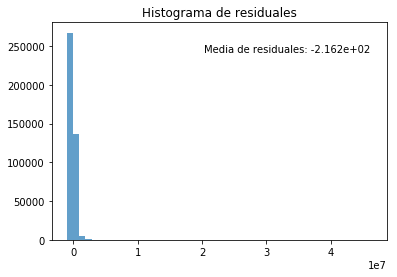

In [57]:
predictions = lr.predict(dataSample)
print "precision sample: ", lr.score(dataSample, targetSample)
f, ax = plt.subplots(1)
ax.hist(targetSample - predictions, bins=50, alpha=0.7)
ax.set_title('Histograma de residuales')
ax.text(0.95, 0.90, 'Media de residuales: {:.3e}'.format(np.mean(targetSample - predictions)),
        transform=ax.transAxes, verticalalignment='top', horizontalalignment='right')

Prediccion del set de test

In [41]:
predictions = lr.predict(data)

In [200]:
final = saveFinalDF(predictions, ids)

In [201]:
final.head()

,id,price_usd
0,3632,1.247484e+07
1,3633,5.288541e+06
2,2263404,8.702557e+06
3,2263405,4.927972e+06
4,2263406,6.199079e+06


# Transformacion no lineal a lineal

#  (Este metodo da precios demasiado altos y es peor que el lineal hecho en el paso anterior)

Si tomamos como ejemplo una función f que toma la forma :  f(x) = a + bx + cx²

La función f es no lineal en función de x pero si es lineal en función de los parámetros desconocidos a, b, y c. O visto de otra manera: podemos sustituir nuestras variables x por un array z tal que: z = [1, x, x²]. Con el que podríamos reescribir nuestra función f como f(z) = a z0 + bz1 + c*z2

Scikit-learn tiene un objeto PolynomialFeatures que nos va a servir para convertir nuestra variable x en un array z del tipo z = [1, x, x2, …, n^n], que es lo que nos interesa.

El resultado de esa transformación se la pasamos a nuestro modelo Ridge. Para facilitar la tarea en este tipo de casos —donde se realizan varios pasos que van desde el pre-tratamiento de los datos hasta un posible post-tratamiento pasando por el entrenamiento—, podemos hacer uso de las Pipeline que nos permiten encadenar multiples estimadores en uno. Esto es especialmente útil cuando hay secuencia de pasos predefinidos en el procesado de datos con, por ejemplo, selección de atributos, normalización y clasificación.

In [24]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [25]:
poly = PolynomialFeatures(degree = 2)
z = poly.fit_transform(dataTrain)
lr = LinearRegression(normalize=True)
lr.fit(z, targetTrain)
lr.score(z, targetTrain)

0.18679831133031699

In [2]:
sampleTransformed = poly.fit_transform(dataSample)
predictionsSamplePlynomial = lr.predict(sampleTransformed)
print "precision sample: ", lr.score(dataSample, targetSample)

In [62]:
DataTransformed = poly.fit_transform(data)
predictions = lr.predict(DataTransformed)

In [210]:
final = saveFinalDF(predictions, ids)

In [211]:
final.head()

,id,price_usd
0,3632,1.001339e+21
1,3633,8.158107e+21
2,2263404,5.498861e+21
3,2263405,8.590666e+20
4,2263406,8.654199e+20


# Decicion Tree

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [132]:
maxDeepList = list(range(3, 23))
regrList =  []
for depth in maxDeepList:
    regr = DecisionTreeRegressor(max_depth = depth)
    regr.fit(dataTrain, targetTrain)
    y_1 = regr.predict(data)
    print("precisión entranamiento: {0: .2f}, depth: {1: }".format(regr.score(dataTrain, targetTrain), depth))

precisión entranamiento:  0.20, depth:  3
precisión entranamiento:  0.27, depth:  4
precisión entranamiento:  0.32, depth:  5
precisión entranamiento:  0.41, depth:  6
precisión entranamiento:  0.43, depth:  7
precisión entranamiento:  0.45, depth:  8
precisión entranamiento:  0.47, depth:  9
precisión entranamiento:  0.49, depth:  10
precisión entranamiento:  0.51, depth:  11
precisión entranamiento:  0.55, depth:  12
precisión entranamiento:  0.59, depth:  13
precisión entranamiento:  0.62, depth:  14
precisión entranamiento:  0.64, depth:  15
precisión entranamiento:  0.67, depth:  16
precisión entranamiento:  0.70, depth:  17
precisión entranamiento:  0.73, depth:  18
precisión entranamiento:  0.75, depth:  19
precisión entranamiento:  0.76, depth:  20
precisión entranamiento:  0.78, depth:  21
precisión entranamiento:  0.79, depth:  22


In [44]:
# Fit regression model
decicionTree = DecisionTreeRegressor(max_depth=100)
decicionTree.fit(dataTrain, targetTrain)
# Predict
predictionDT = decicionTree.predict(data)

In [45]:
samplePredictionDT = decicionTree.predict(dataSample)
print "precision sample: ", decicionTree.score(dataSample, targetSample)

precision sample:  0.899801228983


In [46]:
final = saveFinalDF(predictionDT, ids)

In [51]:
final.head()

,id,price_usd
0,3632,330000.0
1,3633,95000.0
2,2263404,125000.0
3,2263405,105000.0
4,2263406,330000.0


#  Ridge Regression

In [83]:
from sklearn import linear_model

In [84]:
ridgeRegression = linear_model.Ridge(alpha = .5)
ridgeRegression.fit(dataTrain, targetTrain) 
predictionsRR = ridgeRegression.predict(data) 

In [92]:
samplePredictionRR = ridgeRegression.predict(dataSample)
print "precision sample: ", ridgeRegression.score(dataSample, targetSample)

precision sample:  0.0883556986071


In [87]:
final = saveFinalDF(predictionsRR, ids)

In [88]:
final.head()

,id,price_usd
0,3632,1.247483e+07
1,3633,5.288584e+06
2,2263404,8.702583e+06
3,2263405,4.927980e+06
4,2263406,6.199083e+06


# Ridge Complexity

In [89]:
from sklearn import linear_model

In [90]:
ridgeComplexity = linear_model.RidgeCV(alphas = [0.1, 1.0, 10.0])
ridgeComplexity.fit(dataTrain, targetTrain)       
ridgeComplexity.alpha_

10.0

In [91]:
ridgeComplexity.score(dataTrain, targetTrain)

0.088456337638194049

In [93]:
samplePredictionRC = ridgeComplexity.predict(dataSample)
print "precision sample: ", ridgeComplexity.score(dataSample, targetSample)

precision sample:  0.0856249719181


In [94]:
RCPredictions = ridgeComplexity.predict(data)

In [95]:
final = saveFinalDF(RCPredictions, ids)

In [96]:
final.head()

,id,price_usd
0,3632,1.247478e+07
1,3633,5.289504e+06
2,2263404,8.703183e+06
3,2263405,4.928224e+06
4,2263406,6.199271e+06


# LARS Lasso

In [109]:
from sklearn import linear_model

In [113]:
Lars = linear_model.LassoLars(alpha=0.5)
Lars.fit(dataTrain, targetTrain) 
Lars.score(dataTrain, targetTrain)

0.091261947135490171

In [114]:
samplePredictionLars = Lars.predict(dataSample)
print "precision sample: ", Lars.score(dataSample, targetSample)

precision sample:  0.088308627118


In [115]:
LARSPredictions = reg.predict(data)

In [336]:
final = saveFinalDF(LARSPredictions, ids)

In [338]:
final.head()

,id,price_usd
0,3632,-421403.261019
1,3633,194659.708018
2,2263404,-172104.438379
3,2263405,-127896.770630
4,2263406,-57856.757259


# Random Forest Regressor

In [56]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
RF = RandomForestRegressor(n_estimators=1000)
RF.fit(dataTrain, targetTrain)
RF.socre(dataTrain, tragetTrain)

In [ ]:
RF.predict(dataSample)
RF.socre(dataSample, tragetSample)